# ClickBait Project – Feature Engineering on Embeddings

We will:
- Load merged data and embeddings from `data/merged/`.
- Attach embeddings to `title/label`.
- Train/valid/test split and save to `data/clean/`.
- Run PCA/UMAP/t-SNE reductions (fit on train, transform valid/test/full).
- Save reduced embeddings + reducer pickle under `data/clean/<reducer>/` with component count in the name.

## 0. Import Libraries & Modules

In [12]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

DATA_MERGED = PROJECT_ROOT / "data" / "merged"
DATA_CLEAN = PROJECT_ROOT / "data" / "clean"
DATA_CLEAN.mkdir(parents=True, exist_ok=True)

DATA_MERGED, DATA_CLEAN

(PosixPath('/Users/nikosgatos/PycharmProjects/Clickbait_Machine_Learning_Project/data/merged'),
 PosixPath('/Users/nikosgatos/PycharmProjects/Clickbait_Machine_Learning_Project/data/clean'))

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from src.feature_eng import (
    attach_embeddings,
    train_valid_test_split,
    fit_reduce_embeddings,
    plot_pca_explained_variance,
    reduce_and_plot_2d,
    reduce_and_plot_3d
)


NotFoundError: dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/datascience_m5/lib/python3.12/site-packages/tensorflow-plugins/libmetal_plugin.dylib, 0x0006): Library not loaded: @rpath/_pywrap_tensorflow_internal.so
  Referenced from: <8B62586B-B082-3113-93AB-FD766A9960AE> /opt/homebrew/Caskroom/miniforge/base/envs/datascience_m5/lib/python3.12/site-packages/tensorflow-plugins/libmetal_plugin.dylib
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/datascience_m5/lib/python3.12/site-packages/tensorflow-plugins/../_solib_darwin_arm64/_U@local_Uconfig_Utf_S_S_C_Upywrap_Utensorflow_Uinternal___Uexternal_Slocal_Uconfig_Utf/_pywrap_tensorflow_internal.so' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/datascience_m5/lib/python3.12/site-packages/tensorflow-plugins/../_solib_darwin_arm64/_U@local_Uconfig_Utf_S_S_C_Upywrap_Utensorflow_Uinternal___Uexternal_Slocal_Uconfig_Utf/_pywrap_tensorflow_internal.so' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/datascience_m5/bin/../lib/_pywrap_tensorflow_internal.so' (no such file)

## 1. Load & Attach Data

If the train test split have already been done set this to True in order not to recreate them but just read them

In [3]:
ALREADY_EXIST = True

Set `EMBED_PATH` to the embeddings file you saved in `data/merged/`
(e.g., `titles_labels_merged_embed.parquet` or similar). We’ll auto-load based on extension.

In [4]:
# Adjust filename if yours differs
data_path = DATA_MERGED / "data_merged.csv"
data_df = pd.read_csv(data_path)
print(data_df.shape)
display(data_df.head())

(106044, 2)


,title,label
0,"15 Highly Important Questions About Adulthood,...",1.0
1,250 Nuns Just Cycled All The Way From Kathmand...,1.0
2,"Australian comedians ""could have been shot"" du...",0.0
3,Lycos launches screensaver to increase spammer...,0.0
4,Fußball-Bundesliga 2008–09: Goalkeeper Butt si...,0.0


* Pick the embedding file from the merged subfolder (parquet/csv/xlsx).

In [5]:
# Find first embedding file under data/merged (adjust if needed)
embed_candidates = list(DATA_MERGED.glob("**/*embed.*")) + list(DATA_MERGED.glob("**/*_embed.*"))
if not embed_candidates:
    raise FileNotFoundError("No embedding file found under data/merged/")
EMBED_PATH = embed_candidates[0]
print("Using embedding file:", EMBED_PATH)

ext = EMBED_PATH.suffix.lower()
if ext == ".parquet":
    emb_df = pd.read_parquet(EMBED_PATH)
elif ext == ".csv":
    emb_df = pd.read_csv(EMBED_PATH)
elif ext in {".xlsx", ".xls"}:
    emb_df = pd.read_excel(EMBED_PATH)
else:
    raise ValueError(f"Unsupported embedding extension: {ext}")

print("Embeddings shape:", emb_df.shape)
display(emb_df.head())

Using embedding file: c:\Users\user\Desktop\MSc - AI\Εξάμηνο 1ο\Μηχανική Μάθηση\Clickbait_Machine_Learning_Project\data\merged\google__gemma-3-4b-it\data_merged_embed.parquet
Embeddings shape: (106044, 2560)


,0,1,2,3,4,5,6,7,8,9,...,2550,2551,2552,2553,2554,2555,2556,2557,2558,2559
0,-1.523438,-3.093750,2.468750,0.125977,0.707031,-1.179688,0.076172,1.242188,-0.202148,3.109375,...,1.976562,0.953125,2.484375,-0.152344,-0.011353,-2.578125,-0.449219,-1.476562,-0.291016,0.488281
1,0.146484,-2.281250,1.140625,0.519531,-0.184570,-0.933594,-0.621094,0.384766,-0.859375,0.988281,...,0.859375,0.186523,2.062500,-1.281250,-0.123535,-3.562500,0.289062,-0.941406,0.064453,-1.171875
2,-1.265625,-5.781250,2.515625,-0.933594,-0.441406,-1.625000,1.992188,1.359375,-3.437500,0.115234,...,0.082031,0.769531,1.710938,-0.255859,-1.351562,-2.546875,-1.695312,-2.593750,0.968750,-0.875000
3,-2.046875,-5.843750,3.625000,-0.004639,-1.242188,-2.671875,1.539062,2.484375,-3.593750,0.209961,...,2.296875,0.574219,1.523438,-0.147461,-0.875000,-2.453125,-2.546875,-2.281250,0.271484,-0.173828
4,0.246094,0.251953,0.699219,1.375000,-1.109375,0.177734,-1.773438,2.062500,2.296875,0.080566,...,-0.113281,1.546875,1.203125,-0.226562,0.166016,-2.062500,-0.108398,1.421875,-1.328125,-0.363281


* We add a column `embedding` (list of floats) aligned row-wise.

In [6]:
if not ALREADY_EXIST:
    attached_df = attach_embeddings(data_df, emb_df, embed_col="embedding")
    print(attached_df.shape)
    display(attached_df.head())

* Save attached full and train/valid/test splits to `data/clean/`

In [7]:
if not ALREADY_EXIST:
    print("Splitting dataset into train, valid, test...")
    train_df, valid_df, test_df = train_valid_test_split(
        attached_df,
        train_frac=0.8,
        valid_frac=0.1,
        test_frac=0.1,
        random_state=42,
        shuffle=True,
        use_valid=True,
    )

    # Save as parquet to preserve embedding lists
    attached_path = DATA_CLEAN / "attached.parquet"
    train_path = DATA_CLEAN / "train.parquet"
    valid_path = DATA_CLEAN / "valid.parquet"
    test_path = DATA_CLEAN / "test.parquet"

    attached_df.to_parquet(attached_path, index=False)
    train_df.to_parquet(train_path, index=False)
    valid_df.to_parquet(valid_path, index=False)
    test_df.to_parquet(test_path, index=False)
    
    print("Datasets saved to data/clean/")
    
    print("Attached shape:", attached_df.shape)
    print("Train shape:", train_df.shape)
    print("Valid shape:", valid_df.shape)
    print("Test shape:", test_df.shape)
    
    print("Path to saved datasets:")
    print("Attached:", attached_path)
    print("Train:", train_path)
    print("Valid:", valid_path)
    print("Test:", test_path)
else:
    print("Datasets already exist. Loading...")
    train_path = DATA_CLEAN / "train.parquet"
    valid_path = DATA_CLEAN / "valid.parquet"
    test_path = DATA_CLEAN / "test.parquet"
    attached_path = DATA_CLEAN / "attached.parquet"

    train_df = pd.read_parquet(train_path)
    valid_df = pd.read_parquet(valid_path)
    test_df = pd.read_parquet(test_path)
    attached_df = pd.read_parquet(attached_path)

    print("Datasets loaded from data/clean/")
    
    print("Attached shape:", attached_df.shape)
    print("Train shape:", train_df.shape)
    print("Valid shape:", valid_df.shape)
    print("Test shape:", test_df.shape)
    
    print("Path to loaded datasets:")
    print("Attached:", attached_path)
    print("Train:", train_path)
    print("Valid:", valid_path)
    print("Test:", test_path)

Datasets already exist. Loading...
Datasets loaded from data/clean/
Attached shape: (106044, 3)
Train shape: (84835, 3)
Valid shape: (10604, 3)
Test shape: (10605, 3)
Path to loaded datasets:
Attached: c:\Users\user\Desktop\MSc - AI\Εξάμηνο 1ο\Μηχανική Μάθηση\Clickbait_Machine_Learning_Project\data\clean\attached.parquet
Train: c:\Users\user\Desktop\MSc - AI\Εξάμηνο 1ο\Μηχανική Μάθηση\Clickbait_Machine_Learning_Project\data\clean\train.parquet
Valid: c:\Users\user\Desktop\MSc - AI\Εξάμηνο 1ο\Μηχανική Μάθηση\Clickbait_Machine_Learning_Project\data\clean\valid.parquet
Test: c:\Users\user\Desktop\MSc - AI\Εξάμηνο 1ο\Μηχανική Μάθηση\Clickbait_Machine_Learning_Project\data\clean\test.parquet


* Helper to extract numeric embedding matrix

In [8]:
def to_matrix(df: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame(np.vstack(df["embedding"].to_numpy()))

train_emb = to_matrix(train_df)
valid_emb = to_matrix(valid_df)
test_emb = to_matrix(test_df)
full_emb = to_matrix(attached_df)

train_emb.shape, valid_emb.shape, test_emb.shape, full_emb.shape


((84835, 2560), (10604, 2560), (10605, 2560), (106044, 2560))

## 2. Reduction helpers

Fits on train, transforms valid/test/full, saves reduced embeddings and reducer pickle under `data/clean/<algo>/`.
Filenames include the component count, e.g. `train_pca_200.parquet`, `reducer_pca_200.pkl`.

In [9]:
def run_reduction(
    algo: str,
    n_components: int,
    train_emb: pd.DataFrame,
    train_labels: pd.Series,
    valid_emb: pd.DataFrame,
    valid_labels: pd.Series,
    test_emb: pd.DataFrame,
    test_labels: pd.Series,
    out_root: Path,
    random_state: int = 42,
    **kwargs,
):
    algo = algo.lower()
    if algo == "tsne" and n_components > 3:
        raise ValueError("t-SNE only supports up to 3 components with the Barnes-Hut method.")

    out_dir = out_root / algo
    out_dir.mkdir(parents=True, exist_ok=True)

    train_reduced, reducer = fit_reduce_embeddings(
        df=train_emb,
        algorithm=algo,
        n_components=n_components,
        random_state=random_state,
        **kwargs,
    )

    def _transform(mat, labels):
        arr = reducer.transform(mat)
        df = pd.DataFrame(arr, columns=train_reduced.columns)
        df["labels"] = pd.Series(labels).reset_index(drop=True)
        return df

    valid_reduced = _transform(valid_emb, valid_labels)
    test_reduced = _transform(test_emb, test_labels)
    train_reduced = train_reduced.copy()
    train_reduced["labels"] = pd.Series(train_labels).reset_index(drop=True)

    for name, df_ in [
        ("train", train_reduced),
        ("valid", valid_reduced),
        ("test", test_reduced),
    ]:
        out_path = out_dir / f"{name}_{algo}_{n_components}.parquet"
        df_.to_parquet(out_path, index=False)
        print(f"[INFO] Saved {name} -> {out_path}")

    reducer_path = out_dir / f"reducer_{algo}_{n_components}.pkl"
    with open(reducer_path, "wb") as f:
        pickle.dump(reducer, f)
    print(f"[INFO] Saved reducer -> {reducer_path}")

    return train_reduced, valid_reduced, test_reduced, reducer_path

## 3. PCA explained variance

Quick plot for a range of component counts.

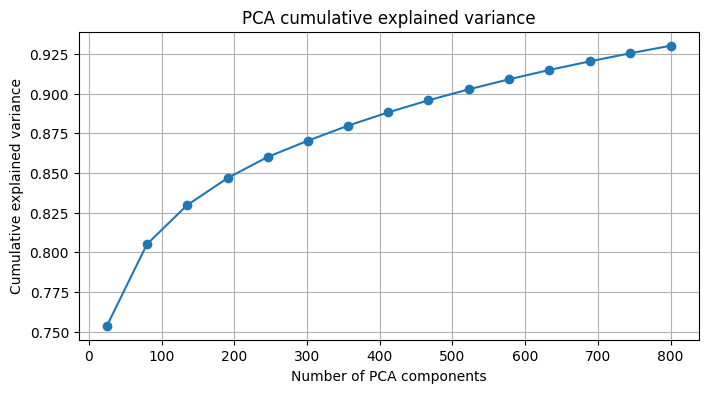

In [13]:
plot_pca_explained_variance(
    df=full_emb,
    max_components=800,
    n_samples=15,
    start_components=25,
    random_state=42,
)

## 4. 2D visualization (fit on train, plot train)

Use the reducer of your choice for a quick scatter (optionally colored by label).

In [7]:
pca2d, pca_reducer_2d = reduce_and_plot_2d(
    df=train_emb,
    algorithm="pca",
    random_state=42,
    hue=train_df["label"],
)

NameError: name 'reduce_and_plot_2d' is not defined

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_spectral_embedding.py:285: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


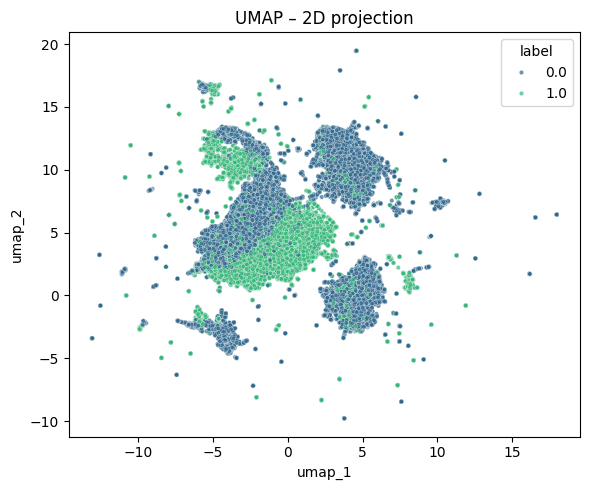

In [19]:
numap2d, umap_reducer_2d = reduce_and_plot_2d(
    df=train_emb,
    algorithm="umap",
    random_state=42,
    hue=train_df["label"],
)

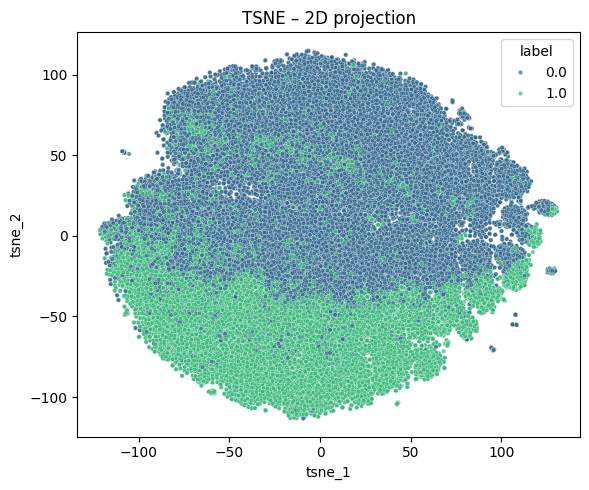

In [17]:
tsne2d, tsne_reducer_2d = reduce_and_plot_2d(
    df=train_emb,
    algorithm="tsne",
    random_state=42,
    hue=train_df["label"],
)

## 5. 3D Visualization (PCA/UMAP/t-SNE)

In [15]:
labels_cat = train_df["label"].astype(int).astype(str)

In [16]:
pca_3d_df, pca_3d_model = reduce_and_plot_3d(
    df=train_emb,
    algorithm="pca",
    random_state=42,
    hue=labels_cat,
    sample_n=10000,
)

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [17]:
umap_3d_df, umap_3d_model = reduce_and_plot_3d(
    df=train_emb,
    algorithm="umap",
    random_state=42,
    hue=labels_cat,
    n_neighbors=15,
    min_dist=0.1,
    sample_n=10000,
)

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [18]:
tsne_3d_df, tsne_3d_model = reduce_and_plot_3d(
    df=train_emb,
    algorithm="tsne",
    random_state=42,
    hue=labels_cat,
    perplexity=30,
    learning_rate="auto",
    init="pca",
    sample_n=10000,
)

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



## 6. Run Reductions

* Reduce the embeddings with PCA

In [10]:
# PCA → 200 dims
pca200_train, pca200_valid, pca200_test, pca200_model = run_reduction(
    algo="pca",
    n_components=200,
    train_emb=train_emb,
    train_labels=train_df["label"],
    valid_emb=valid_emb,
    valid_labels=valid_df["label"],
    test_emb=test_emb,
    test_labels=test_df["label"],
    out_root=DATA_CLEAN,
    random_state=42,
)

[INFO] Saved train -> c:\Users\user\Desktop\MSc - AI\Εξάμηνο 1ο\Μηχανική Μάθηση\Clickbait_Machine_Learning_Project\data\clean\pca\train_pca_200.parquet
[INFO] Saved valid -> c:\Users\user\Desktop\MSc - AI\Εξάμηνο 1ο\Μηχανική Μάθηση\Clickbait_Machine_Learning_Project\data\clean\pca\valid_pca_200.parquet
[INFO] Saved test -> c:\Users\user\Desktop\MSc - AI\Εξάμηνο 1ο\Μηχανική Μάθηση\Clickbait_Machine_Learning_Project\data\clean\pca\test_pca_200.parquet
[INFO] Saved reducer -> c:\Users\user\Desktop\MSc - AI\Εξάμηνο 1ο\Μηχανική Μάθηση\Clickbait_Machine_Learning_Project\data\clean\pca\reducer_pca_200.pkl


In [11]:
# PCA → 500 dims
pca500_train, pca500_valid, pca500_test, pca500_model = run_reduction(
    algo="pca",
    n_components=500,
    train_emb=train_emb,
    train_labels=train_df["label"],
    valid_emb=valid_emb,
    valid_labels=valid_df["label"],
    test_emb=test_emb,
    test_labels=test_df["label"],
    out_root=DATA_CLEAN,
    random_state=42,
)

[INFO] Saved train -> c:\Users\user\Desktop\MSc - AI\Εξάμηνο 1ο\Μηχανική Μάθηση\Clickbait_Machine_Learning_Project\data\clean\pca\train_pca_500.parquet
[INFO] Saved valid -> c:\Users\user\Desktop\MSc - AI\Εξάμηνο 1ο\Μηχανική Μάθηση\Clickbait_Machine_Learning_Project\data\clean\pca\valid_pca_500.parquet
[INFO] Saved test -> c:\Users\user\Desktop\MSc - AI\Εξάμηνο 1ο\Μηχανική Μάθηση\Clickbait_Machine_Learning_Project\data\clean\pca\test_pca_500.parquet
[INFO] Saved reducer -> c:\Users\user\Desktop\MSc - AI\Εξάμηνο 1ο\Μηχανική Μάθηση\Clickbait_Machine_Learning_Project\data\clean\pca\reducer_pca_500.pkl


* Reduce the embeddings with UMAP

In [12]:
# UMAP → 200 dims (requires `umap-learn`)
umap200_train, umap200_valid, umap200_test, umap200_model = run_reduction(
    algo="umap",
    n_components=200,
    train_emb=train_emb,
    train_labels=train_df["label"],
    valid_emb=valid_emb,
    valid_labels=valid_df["label"],
    test_emb=test_emb,
    test_labels=test_df["label"],
    out_root=DATA_CLEAN,
    random_state=42,
    n_neighbors=15,
    min_dist=0.1,
)

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\sparse\_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


[INFO] Saved train -> c:\Users\user\Desktop\MSc - AI\Εξάμηνο 1ο\Μηχανική Μάθηση\Clickbait_Machine_Learning_Project\data\clean\umap\train_umap_200.parquet
[INFO] Saved valid -> c:\Users\user\Desktop\MSc - AI\Εξάμηνο 1ο\Μηχανική Μάθηση\Clickbait_Machine_Learning_Project\data\clean\umap\valid_umap_200.parquet
[INFO] Saved test -> c:\Users\user\Desktop\MSc - AI\Εξάμηνο 1ο\Μηχανική Μάθηση\Clickbait_Machine_Learning_Project\data\clean\umap\test_umap_200.parquet
[INFO] Saved reducer -> c:\Users\user\Desktop\MSc - AI\Εξάμηνο 1ο\Μηχανική Μάθηση\Clickbait_Machine_Learning_Project\data\clean\umap\reducer_umap_200.pkl


In [13]:
# UMAP → 500 dims
umap500_train, umap500_valid, umap500_test, umap500_model = run_reduction(
    algo="umap",
    n_components=500,
    train_emb=train_emb,
    train_labels=train_df["label"],
    valid_emb=valid_emb,
    valid_labels=valid_df["label"],
    test_emb=test_emb,
    test_labels=test_df["label"],
    out_root=DATA_CLEAN,
    random_state=42,
    n_neighbors=15,
    min_dist=0.1,
)

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\sparse\_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


[INFO] Saved train -> c:\Users\user\Desktop\MSc - AI\Εξάμηνο 1ο\Μηχανική Μάθηση\Clickbait_Machine_Learning_Project\data\clean\umap\train_umap_500.parquet
[INFO] Saved valid -> c:\Users\user\Desktop\MSc - AI\Εξάμηνο 1ο\Μηχανική Μάθηση\Clickbait_Machine_Learning_Project\data\clean\umap\valid_umap_500.parquet
[INFO] Saved test -> c:\Users\user\Desktop\MSc - AI\Εξάμηνο 1ο\Μηχανική Μάθηση\Clickbait_Machine_Learning_Project\data\clean\umap\test_umap_500.parquet
[INFO] Saved reducer -> c:\Users\user\Desktop\MSc - AI\Εξάμηνο 1ο\Μηχανική Μάθηση\Clickbait_Machine_Learning_Project\data\clean\umap\reducer_umap_500.pkl


## 7. Display Reduced Embeddings

In [4]:
def load_reduced(algo: str, n_components: int, split: str) -> pd.DataFrame:
    """
    Load a reduced embedding parquet from data/clean/<algo>/<split>_<algo>_<n_components>.parquet
    (split ∈ {train, valid, test}).
    """
    path = DATA_CLEAN / algo / f"{split}_{algo}_{n_components}.parquet"
    df = pd.read_parquet(path)
    print(f"Loaded {path} -> {df.shape}")
    return df

In [5]:
pca200_train = load_reduced("pca", 200, "train")
pca200_valid = load_reduced("pca", 200, "valid")
pca200_test = load_reduced("pca", 200, "test")

pca500_train = load_reduced("pca", 500, "train")
pca500_valid = load_reduced("pca", 500, "valid")
pca500_test = load_reduced("pca", 500, "test")

ArrowInvalid: Could not open Parquet input source '<Buffer>': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.

In [5]:
umap200_train = load_reduced("umap", 200, "train")
umap200_valid = load_reduced("umap", 200, "valid")
umap200_test = load_reduced("umap", 200, "test")

umap500_train = load_reduced("umap", 500, "train")
umap500_valid = load_reduced("umap", 500, "valid")
umap500_test = load_reduced("umap", 500, "test")

Loaded c:\Users\user\Desktop\MSc - AI\Εξάμηνο 1ο\Μηχανική Μάθηση\Clickbait_Machine_Learning_Project\data\clean\umap\train_umap_200.parquet -> (84835, 201)
Loaded c:\Users\user\Desktop\MSc - AI\Εξάμηνο 1ο\Μηχανική Μάθηση\Clickbait_Machine_Learning_Project\data\clean\umap\valid_umap_200.parquet -> (10604, 201)
Loaded c:\Users\user\Desktop\MSc - AI\Εξάμηνο 1ο\Μηχανική Μάθηση\Clickbait_Machine_Learning_Project\data\clean\umap\test_umap_200.parquet -> (10605, 201)
Loaded c:\Users\user\Desktop\MSc - AI\Εξάμηνο 1ο\Μηχανική Μάθηση\Clickbait_Machine_Learning_Project\data\clean\umap\train_umap_500.parquet -> (84835, 501)
Loaded c:\Users\user\Desktop\MSc - AI\Εξάμηνο 1ο\Μηχανική Μάθηση\Clickbait_Machine_Learning_Project\data\clean\umap\valid_umap_500.parquet -> (10604, 501)
Loaded c:\Users\user\Desktop\MSc - AI\Εξάμηνο 1ο\Μηχανική Μάθηση\Clickbait_Machine_Learning_Project\data\clean\umap\test_umap_500.parquet -> (10605, 501)


In [7]:
umap500_train.head()

,umap_1,umap_2,umap_3,umap_4,umap_5,umap_6,umap_7,umap_8,umap_9,umap_10,...,umap_492,umap_493,umap_494,umap_495,umap_496,umap_497,umap_498,umap_499,umap_500,labels
0,9.334062,5.016025,5.328325,4.978258,1.641165,4.413798,5.827141,3.374801,4.767972,4.853283,...,4.991783,4.904005,5.041192,4.963029,5.045759,5.035073,5.155313,4.998848,5.023656,0.0
1,9.357007,5.025758,5.685514,5.006476,0.434648,3.854208,6.536222,2.908327,4.671115,2.818283,...,4.961070,4.857306,5.031448,5.048440,5.173259,5.075552,5.190748,5.015749,5.014325,1.0
2,9.314624,4.995767,4.759700,4.996031,4.043061,5.374736,3.929870,9.869943,5.651787,3.894861,...,5.096212,5.087844,5.016516,4.909857,4.919668,4.903786,4.997077,4.880939,4.961647,0.0
3,9.325440,5.011119,5.110687,4.962512,2.208976,4.693722,5.542806,3.112980,4.757354,5.970803,...,4.993001,4.920928,5.031424,4.922039,4.989940,5.024601,5.141144,4.996424,5.025998,0.0
4,9.340708,5.018109,5.428872,4.986674,1.364167,4.274668,5.971249,3.490057,4.772830,4.255072,...,4.990185,4.886710,5.033436,4.971483,5.056034,5.038480,5.160019,4.993631,5.025416,0.0
